In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.image import imread
from PIL import Image
import os
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

## I took at least 100 images per class (apparel, chair, footwear) for my 3 categories for my classification model.

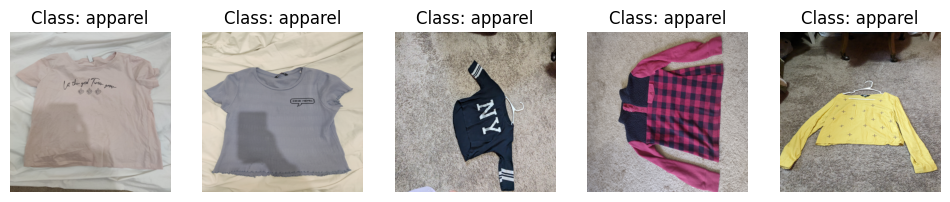

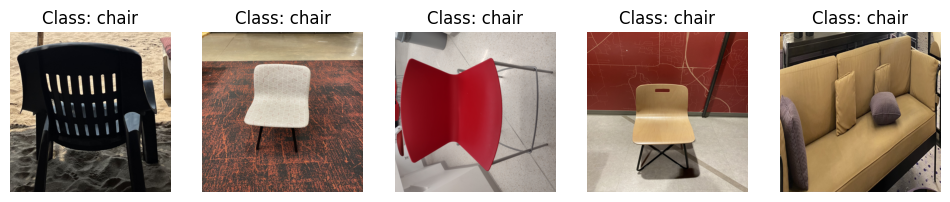

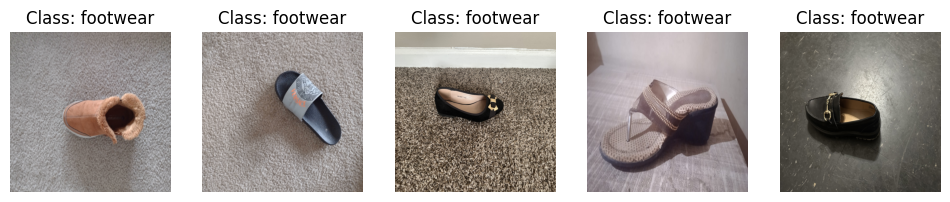

In [ ]:
import random

category = ['apparel', 'chair', 'footwear']
label = {'apparel': 0, 'chair': 1, 'footwear': 2}
folder_path = '/content/drive/MyDrive/Colab Notebooks/Assignment4'
images = []
labels = []
for cat in category:
  dir_path = os.path.join(folder_path, cat)
  image_list = os.listdir(dir_path)
  rand_image = random.sample(image_list, 5)
  plt.figure(figsize=(12, 10))
  index = 0
  for file in rand_image:
    image = Image.open(os.path.join(dir_path,file))
    image = np.array(image.resize((320, 320)))
    index += 1
    plt.subplot(1, 5, index)
    plt.imshow(image.reshape(320, 320, 3))
    plt.title("Class: {}".format(cat))
    plt.axis("off")

plt.show()

For each category, we are keeping 60% of the images as training data. Remaining 40% images are divided equally to create testing and validation data. This gives us a 60-20-20 split for train, test and validation data. These splitted images are stored in separate folders created for each of the train, test and validation dataset.

In [ ]:
import shutil
import math

category = ['apparel', 'chair', 'footwear']
label = {'apparel': 0, 'chair': 1, 'footwear': 2}
directory = ['train', 'test', 'valid']
folder_path = '/content/drive/MyDrive/Colab Notebooks/Assignment4'
for dir in directory:
    for cat in category:
        os.makedirs(os.path.join(folder_path, dir, cat), exist_ok=True)

for cat in category:
  dir_path = os.path.join(folder_path, cat)
  image_list = os.listdir(dir_path)
  print(f"Found {len(image_list)} images in {cat} folder")
  train_size = math.floor(len(image_list)*0.6)
  test_size = math.floor(len(image_list)*0.2)
  train = image_list[:train_size]
  valid = image_list[train_size:train_size+test_size]
  test = image_list[train_size+test_size:]
  print(f"{cat}: train_size = {train_size}, validation_size = {test_size}, test_size = {test_size}")
  for img in train:
      shutil.copy(os.path.join(dir_path, img), os.path.join(folder_path, 'train', cat))
  for img in valid:
      shutil.copy(os.path.join(dir_path, img), os.path.join(folder_path, 'valid', cat))
  for img in test:
      shutil.copy(os.path.join(dir_path, img), os.path.join(folder_path, 'test', cat))

Found 101 images in apparel folder
apparel: train_size = 60, validation_size = 20, test_size = 20
Found 100 images in chair folder
chair: train_size = 60, validation_size = 20, test_size = 20
Found 113 images in footwear folder
footwear: train_size = 67, validation_size = 22, test_size = 22


## Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.

* As part of preprocessing, we are utilizing Keras preprocessing utility _image_dataset_from_directory_ to get the images in the form of dataset.
* On our dataset, we are applying random flips and random rotation as part of data augmentation.
* Next we defined a pipeline that applies these data augmentation to each element of the training data set in parallel.
* We are also using _prefetch_ to avoid I/O blocking.

In [ ]:
batch_size = 32

train_set = tf.keras.utils.image_dataset_from_directory(
os.path.join(folder_path, 'train'), image_size=(224, 224), batch_size=batch_size)
valid_set = tf.keras.utils.image_dataset_from_directory(
os.path.join(folder_path, 'valid'), image_size=(224, 224), batch_size=batch_size)
test_set = tf.keras.utils.image_dataset_from_directory(
os.path.join(folder_path, 'test'), image_size=(224, 224), batch_size=batch_size)

Found 187 files belonging to 3 classes.
Found 62 files belonging to 3 classes.
Found 65 files belonging to 3 classes.


In [ ]:
train_set.class_names

['apparel', 'chair', 'footwear']

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

In [ ]:
train_set.prefetch(buffer_size=AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# this function plot accuracy and loss of traning vs validation data
def plot_model(history):
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

## Fine-tuning a pretrained model.

We are using ResNet50 as the pretrained model for our data. It is convonutional neural network with 50 layers trained to categorize images in 1000 different categories.

In [ ]:
base_model = tf.keras.applications.ResNet50(weights="imagenet",
                                                  include_top=False)

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:


#optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics=["accuracy"])
history_resnet = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=5)

Epoch 1/5
6/6 [==============================] - 91s 11s/step - loss: 0.7332 - accuracy: 0.6791 - val_loss: 0.1330 - val_accuracy: 0.9677
Epoch 2/5
6/6 [==============================] - 88s 11s/step - loss: 0.1052 - accuracy: 0.9519 - val_loss: 0.2030 - val_accuracy: 0.9032
Epoch 3/5
6/6 [==============================] - 77s 11s/step - loss: 0.0387 - accuracy: 0.9786 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 4/5
6/6 [==============================] - 78s 10s/step - loss: 0.0519 - accuracy: 0.9893 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 5/5
6/6 [==============================] - 76s 11s/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.0478 - val_accuracy: 0.9677


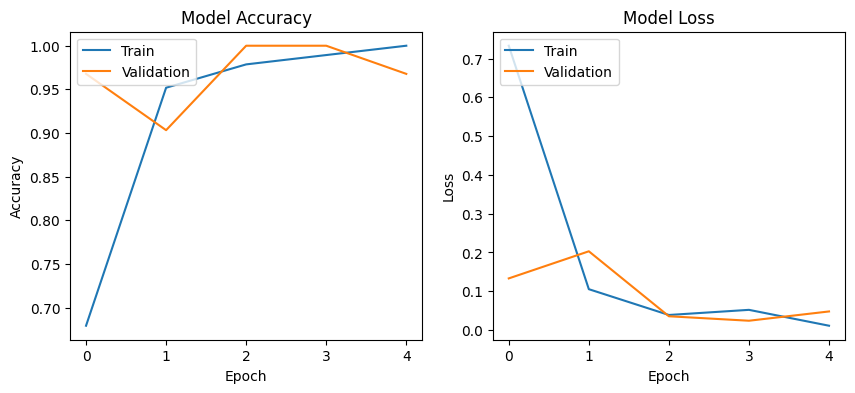

In [ ]:
plot_model(history_resnet)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_set)

3/3 [==============================] - 19s 4s/step - loss: 0.0597 - accuracy: 0.9846


With ResNet50 we got **98.46%** accuracy on test data. This is quite good accuracy. The reason behind it is the convonutional structute and well trained weights of ResNet50. Below are few examples of correct/incorrect classification.

In [ ]:
resnet_prediction = model.predict(test_set)

3/3 [==============================] - 22s 4s/step


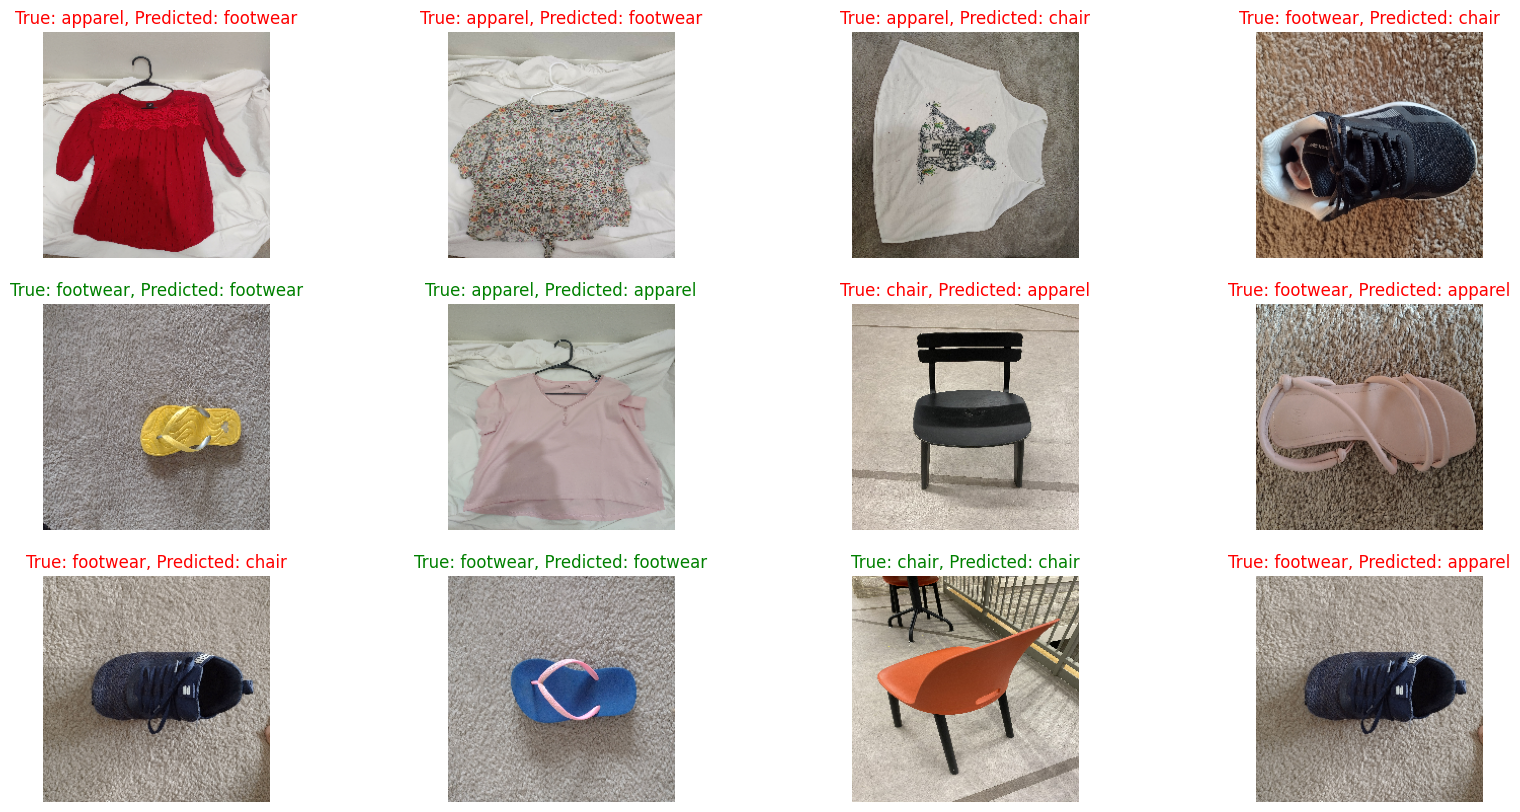

In [ ]:

plt.figure(figsize=(20, 10))
index = 0
for images, labels in test_set.take(1):
    for i in range(12):
        index += 1
        predicted_label = np.argmax(resnet_prediction[i])
        true_label = labels[i]
        title_color = "green" if predicted_label == true_label else "red"
        plt.subplot(3, 4, index)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {category[true_label]}, Predicted: {category[predicted_label]}", color=title_color)
        plt.axis("off")

plt.show()

## Training from scratch (without pretraining) a deep neural network that contains convolutional layers on this dataset.

In this section, we are building our model from scratch and training it using _adam_ optimizer in _10_ epochs.

In [ ]:
num_classes = 3

my_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, 7, activation='relu'),
  tf.keras.layers.MaxPooling2D((3,3)),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((3,3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.GlobalAvgPool2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
my_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics=["accuracy"])
history_mymodel2 = my_model.fit(train_set,
                    validation_data=valid_set,
                    epochs=10)

Epoch 1/10
7/7 [==============================] - 80s 8s/step - loss: 1.1194 - accuracy: 0.5805 - val_loss: 1.0791 - val_accuracy: 0.4386
Epoch 2/10
7/7 [==============================] - 82s 9s/step - loss: 1.0024 - accuracy: 0.6098 - val_loss: 1.0312 - val_accuracy: 0.5088
Epoch 3/10
7/7 [==============================] - 90s 10s/step - loss: 1.2013 - accuracy: 0.5463 - val_loss: 1.0042 - val_accuracy: 0.5877
Epoch 4/10
7/7 [==============================] - 86s 9s/step - loss: 1.1739 - accuracy: 0.6000 - val_loss: 1.0083 - val_accuracy: 0.5088
Epoch 5/10
7/7 [==============================] - 86s 10s/step - loss: 0.8747 - accuracy: 0.6244 - val_loss: 0.9855 - val_accuracy: 0.5088
Epoch 6/10
7/7 [==============================] - 88s 10s/step - loss: 0.9358 - accuracy: 0.6146 - val_loss: 0.9148 - val_accuracy: 0.6140
Epoch 7/10
7/7 [==============================] - 83s 9s/step - loss: 0.9453 - accuracy: 0.6439 - val_loss: 0.8667 - val_accuracy: 0.6491
Epoch 8/10
7/7 [===============

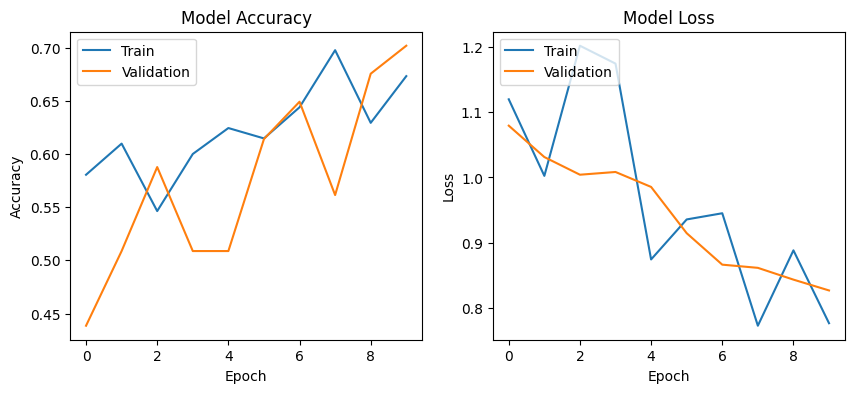

In [ ]:
plot_model(history_mymodel2)

In [ ]:
test_loss, test_accuracy = my_model.evaluate(test_set)

5/5 [==============================] - 18s 861ms/step - loss: 0.8601 - accuracy: 0.7000


We this model we got **70%** accuracy on test data. Though it is a decent accuracy, it is not as good as ResNet50. The reason for this behaviour is that
 ResNet50 is pretrained on a massive dataset of images 1000 categories. This huge data allows the model to learn general features like edges etc. relevant for image classification. On the other hand, our model is trained on very small amount of data putting limitaion on its ability to learn relevant image features.

Below are few examples of correct/incorrect classification.

3/3 [==============================] - 10s 576ms/step


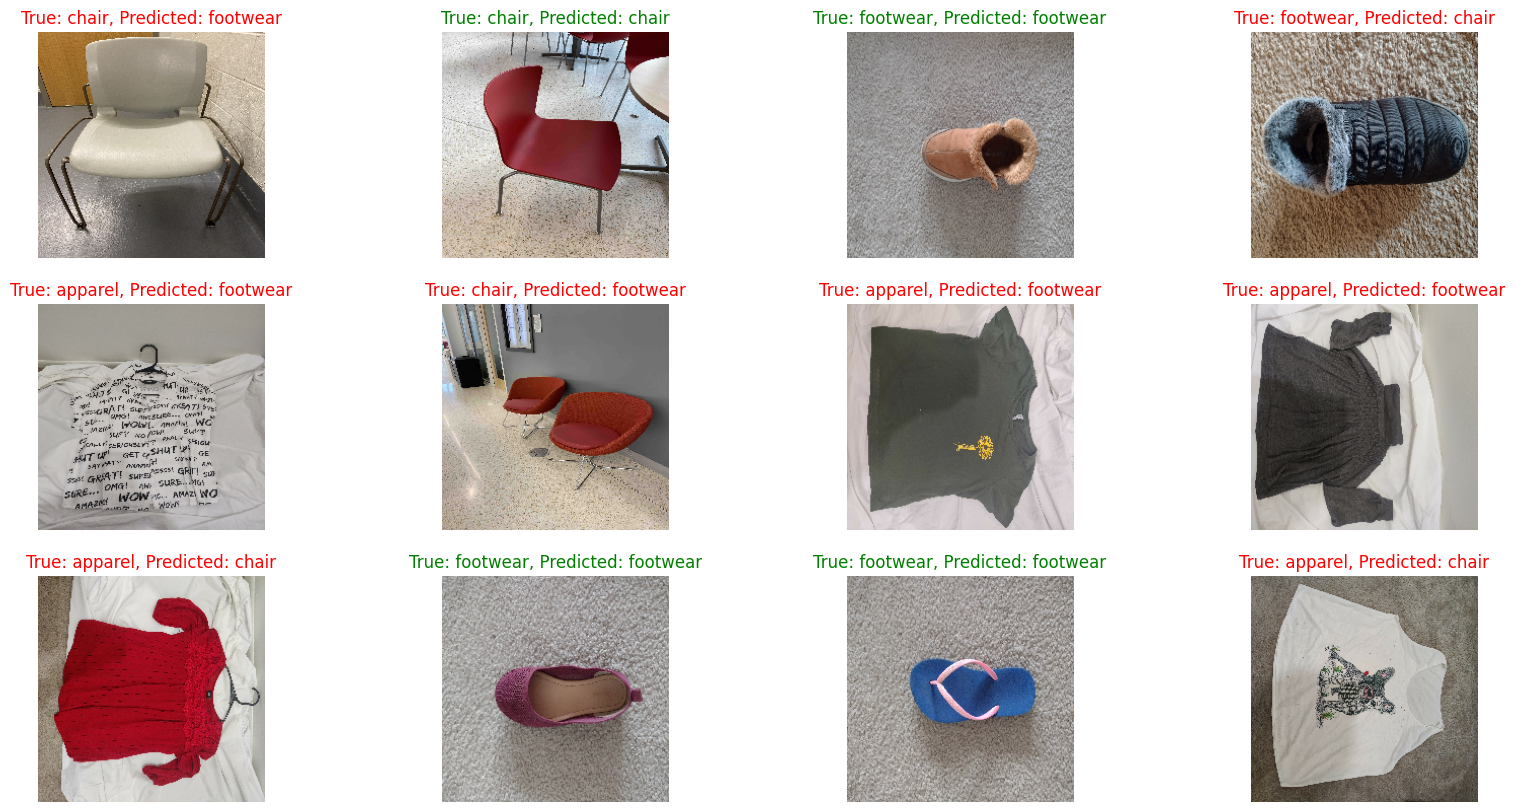

In [ ]:
mymodel_prediction = my_model.predict(test_set)

plt.figure(figsize=(20, 10))
index = 0
for images, labels in test_set.take(1):
    for i in range(12):
        index += 1
        predicted_label = np.argmax(mymodel_prediction[i])
        true_label = labels[i]
        title_color = "green" if predicted_label == true_label else "red"
        plt.subplot(3, 4, index)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {category[true_label]}, Predicted: {category[predicted_label]}", color=title_color)
        plt.axis("off")

plt.show()